In [1]:
EXP_NAME = "resnet50_new_preprocessing"
KAGGLE = False

In [ ]:
import shutil
import os
import sys

In [ ]:
if (KAGGLE): 
    SRC = "/kaggle/input/challenge2/ANN"
    DST = "/kaggle/working/ANN"
    
    if not os.path.exists(DST):
        shutil.copytree(SRC, DST)
    
    os.chdir(DST)
    
    if DST not in sys.path:
        sys.path.insert(0, DST)
    
    print("cwd:", os.getcwd())
    print("data dir writable:", os.access(os.path.join(DST, "data"), os.W_OK))
    
    
    PROJECT_ROOT = "/kaggle/working/ANN"
    os.environ["TORCH_HOME"] = os.path.join(PROJECT_ROOT, "torch")
    print("TORCH_HOME =", os.environ["TORCH_HOME"])
    
    os.chdir(PROJECT_ROOT)
    
    print(os.getcwd())
    print(os.listdir())

In [2]:
# Cell 1 - Setup, imports, scelta esperimento

import torch
from sklearn.metrics import classification_report

if (not KAGGLE):
    # Add local_lib to path BEFORE importing torch and other packages
    BASE_DIR = os.getcwd()
    LOCAL_LIB = os.path.join(BASE_DIR, 'local_lib')
    if os.path.exists(LOCAL_LIB) and LOCAL_LIB not in sys.path:
        sys.path.insert(0, LOCAL_LIB)


    try:
        import google.colab  # type: ignore
        IN_COLAB = True
    except ImportError:
        IN_COLAB = False

    if IN_COLAB:
        from google.colab import drive  # type: ignore
        drive.mount("/content/drive")
        PROJECT_ROOT = "/content/drive/MyDrive/[2025-2026] AN2DL/challenge2"
    else:
        PROJECT_ROOT = os.getcwd()

    os.chdir(PROJECT_ROOT)
    if PROJECT_ROOT not in sys.path:
        sys.path.append(PROJECT_ROOT)

print("Project root:", PROJECT_ROOT)
print("Working dir:", os.getcwd())

# Force reload of config module to get latest changes
import importlib
if 'includes.config' in sys.modules:
    importlib.reload(sys.modules['includes.config'])

from includes.config import TrainingConfig, GRID_SEARCH_SPACES
from includes.data_utils import (
    load_labels_and_split,
    load_full_labels,
    get_transforms,
    create_dataloaders,
)

from includes.model_utils import (
    build_model,
    create_criterion_optimizer_scheduler,
    train_model,
    evaluate,
)
from includes.inference_utils import create_test_loader, run_inference_and_save

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Verifica che la chiave esista
print("\nAvailable experiments in GRID_SEARCH_SPACES:")
for exp in GRID_SEARCH_SPACES.keys():
    print(f"  - {exp}")

# base cfg con default (paths, val_size, ecc.)
cfg = TrainingConfig(exp_name=EXP_NAME)
cfg.project_root = PROJECT_ROOT
cfg.out_dir = "out"

# griglia associata a questo esperimento
if EXP_NAME not in GRID_SEARCH_SPACES:
    raise KeyError(f"Experiment '{EXP_NAME}' not found in GRID_SEARCH_SPACES. Available: {list(GRID_SEARCH_SPACES.keys())}")

param_grid = GRID_SEARCH_SPACES[EXP_NAME]
param_grid

Project root: c:\Users\danie\ANN
Working dir: c:\Users\danie\ANN
Using device: cuda

Available experiments in GRID_SEARCH_SPACES:
  - preprocessing
  - test
  - resnet50_img384
  - resnet50_img384_preprocessing
  - resnet50_img384_preprocessing_augementation_test
  - resnet50_img384_preprocessing_augementation_10_copies
  - resnet50_kfold_sweep
  - resnet50_kfold_cropbbox_30ep
  - resnet50_cropbbox_30ep_holdout_amp
  - resnet50_img384_pp_crop_bbox_offaug4_strong
  - resnet50_img384_pp_crop_bbox_offaug2_soft
  - resnet50_new_preprocessing
  - resnet50_new_preprocessing_noamp
  - resnet50_kfold_50ep_gridsearch
  - resnet50_new_preprocessing_new_validation
  - resnet50_new_preprocessing_new_validation_kfold
  - resnet50_424_augmentation_weight-epoch-grid
  - resnet50_424_lightpreproc_nooffaug_weight-epoch-grid
  - resnet50_optimized_40ep


{'train_img_dir': ['pp_train_data'],
 'test_img_dir': ['pp_test_data'],
 'labels_csv': ['pp_train_labels.csv'],
 'pp_remove_shrek': [True],
 'pp_fix_stained': [True],
 'pp_split_doubles': [True],
 'pp_remove_black_rect': [True],
 'pp_padding_square': [False],
 'pp_crop_to_mask': [False],
 'pp_augmentation_enabled': [False],
 'pp_crop_padding': [10],
 'pp_target_size': [384],
 'pp_strong_rotation_degrees': [15],
 'pp_strong_zoom_min': [0.8],
 'pp_strong_zoom_max': [1.0],
 'pp_strong_brightness': [0.2],
 'pp_strong_contrast': [0.2],
 'pp_strong_saturation': [0.2],
 'pp_strong_hue': [0.05],
 'pp_strong_random_erasing_p': [0.1],
 'pp_smart_discard_threshold': [0.02],
 'pp_split_into_tiles': [True],
 'pp_remove_empty_masks': [True],
 'pp_darken_outside_mask': [False],
 'use_roi_crop': [True],
 'roi_padding': [10],
 'execute': [True],
 'backbone': ['resnet50'],
 'img_size': [384],
 'batch_size': [16],
 'num_workers': [4],
 'lr': [0.0001],
 'weight_decay': [0.0001],
 'epochs': [50],
 'use_sch

In [3]:
# Preprocessing configuration and optional run

import os
import sys
import json
import subprocess

from includes.config import PREPROCESSING_KEYS

# Flag "preprocessing": if False, do not run preprocessing and do not check pp_ params
RUN_PREPROCESSING = True  # set to False if you already have pp_* data and want to skip

def build_preprocessing_config(param_grid: dict) -> dict:
    """
    Extract offline preprocessing config from param_grid.

    Logical constraint: for every key in PREPROCESSING_KEYS
    that appears in the param_grid, there MUST be exactly one value
    (no grid search on preprocessing). If not, raise an error.
    """
    preproc_cfg = {}
    for key in PREPROCESSING_KEYS:
        if key in param_grid:
            values = param_grid[key]
            if not isinstance(values, (list, tuple)) or len(values) != 1:
                raise ValueError(
                    f"Preprocessing parameter '{key}' must have exactly ONE value in the grid. "
                    f"Current values: {values}"
                )
            preproc_cfg[key] = values[0]
    return preproc_cfg


if RUN_PREPROCESSING:
    # 1) Build preprocessing config from grid search config
    preproc_cfg = build_preprocessing_config(param_grid)

    print("========== PREPROCESSING CONFIG ==========")
    for k, v in preproc_cfg.items():
        print(f"{k}: {v}")
    print("==========================================")

    # 2) Call preprocessing/preprocessing.py passing the config as JSON
    preproc_script = os.path.join(PROJECT_ROOT, "preprocessing", "preprocessing.py")

    cmd = [
        sys.executable,               # current Python interpreter
        preproc_script,
        json.dumps(preproc_cfg),      # first argument: JSON with pp_* config
    ]

    print("\n>>> Running offline preprocessing...")
    completed = subprocess.run(cmd, check=True)
    print(">>> Preprocessing finished with returncode:", completed.returncode)
else:
    print("RUN_PREPROCESSING=False: skipping preprocessing and pp_ parameter checks.")


if param_grid.get("execute", True):
    print("\n>>> Proceeding to training phase...")
else:
    print("\n>>> 'execute' flag is False: skipping training phase.")
    sys.exit(0)

# 3) Build a new param_grid for TRAINING ONLY (without preprocessing keys)
train_param_grid = {
    k: v for k, v in param_grid.items() 
    if k not in PREPROCESSING_KEYS and k != 'execute'
}

print("\nTraining param_grid keys:", list(train_param_grid.keys()))


========== PREPROCESSING CONFIG ==========
pp_remove_shrek: True
pp_fix_stained: True
pp_split_doubles: True
pp_remove_black_rect: True
pp_padding_square: False
pp_crop_to_mask: False
pp_split_into_tiles: True
pp_remove_empty_masks: True
pp_darken_outside_mask: False
pp_augmentation_enabled: False
pp_target_size: 384
pp_crop_padding: 10
pp_smart_discard_threshold: 0.02
pp_strong_rotation_degrees: 15
pp_strong_zoom_min: 0.8
pp_strong_zoom_max: 1.0
pp_strong_brightness: 0.2
pp_strong_contrast: 0.2
pp_strong_saturation: 0.2
pp_strong_hue: 0.05
pp_strong_random_erasing_p: 0.1
use_roi_crop: True
roi_padding: 10

>>> Running offline preprocessing...
>>> Preprocessing finished with returncode: 0

>>> Proceeding to training phase...

Training param_grid keys: ['train_img_dir', 'test_img_dir', 'labels_csv', 'backbone', 'img_size', 'batch_size', 'num_workers', 'lr', 'weight_decay', 'epochs', 'use_scheduler', 'use_masks', 'mask_mode', 'use_amp', 'cv_type', 'n_splits', 'val_size']


In [ ]:
# Cell 2 - Grid search with optional StratifiedKFold (TRAINING ONLY)

import itertools
import copy
import numpy as np
import pandas as pd
import torch
from sklearn.model_selection import StratifiedKFold

base_cfg = cfg  # base config for this experiment (already has exp_name, project_root, etc.)

# IMPORTANT: use ONLY training grid (without pp_* keys)
keys = list(train_param_grid.keys())
values_list = [train_param_grid[k] for k in keys]
combos = list(itertools.product(*values_list))
n_combos = len(combos)

print("==============================================================")
print(f"GRID SEARCH for experiment '{EXP_NAME}' with {n_combos} combinations")
print("Param keys (training only):", keys)
print("==============================================================")

results = []
best_val_f1 = -1.0
best_cfg = None
best_state_dict = None
best_idx_to_label = None
best_val_t = None

for i, values in enumerate(combos, start=1):
    params = dict(zip(keys, values))

    print("\n--------------------------------------------------------------")
    print(f"[Grid {i}/{n_combos}] params = {params}")

    # Validation strategy from params (fallback to holdout)
    cv_type = params.get("cv_type", "holdout")
    n_splits = int(params.get("n_splits", 5))

    # 1) Copy base cfg and attach all params as attributes
    cfg_i = copy.deepcopy(base_cfg)
    for k, v in params.items():
        setattr(cfg_i, k, v)

    # 2) Common: full labels + transforms
    labels_df, unique_labels, label_to_idx, idx_to_label_i = load_full_labels(cfg_i)
    train_t_i, val_t_i = get_transforms(cfg_i)
    num_classes = len(unique_labels)

    fold_f1s = []
    best_state_i = None

    if cv_type == "kfold":
        # ----- Stratified K-Fold -----
        print(f"  >> Using StratifiedKFold with {n_splits} folds")

        skf = StratifiedKFold(
            n_splits=n_splits,
            shuffle=True,
            random_state=cfg_i.random_seed,
        )

        best_fold_f1 = -1.0

        for fold, (train_idx, val_idx) in enumerate(
            skf.split(labels_df, labels_df["label_idx"]), start=1
        ):
            print(f"    [Fold {fold}/{n_splits}]")

            train_df = labels_df.iloc[train_idx].reset_index(drop=True)
            val_df = labels_df.iloc[val_idx].reset_index(drop=True)

            train_loader_i, val_loader_i = create_dataloaders(
                cfg_i, train_df, val_df, train_t_i, val_t_i
            )

            model_i = build_model(cfg_i, num_classes=num_classes, device=device)
            criterion_i, optimizer_i, scheduler_i = create_criterion_optimizer_scheduler(
                cfg_i, model_i, train_df, device
            )

            best_state_fold, history_fold = train_model(
                cfg_i,
                model_i,
                train_loader_i,
                val_loader_i,
                criterion_i,
                optimizer_i,
                scheduler_i,
                device,
            )

            val_f1_list = history_fold.get("val_f1", history_fold.get("val_acc", []))
            fold_best_f1 = max(val_f1_list) if val_f1_list else 0.0
            fold_f1s.append(fold_best_f1)
            print(f"    >> Fold best F1: {fold_best_f1:.4f}")

            if fold_best_f1 > best_fold_f1:
                best_fold_f1 = fold_best_f1
                best_state_i = copy.deepcopy(best_state_fold)

            del model_i
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

        run_best_f1 = float(np.mean(fold_f1s))
        print(f"  >> Mean F1 over {n_splits} folds: {run_best_f1:.4f}")

    else:
        # ----- Standard hold-out validation (current behaviour) -----
        train_df, val_df, unique_labels, label_to_idx, idx_to_label_i = load_labels_and_split(
            cfg_i
        )
        train_t_i, val_t_i = get_transforms(cfg_i)
        train_loader_i, val_loader_i = create_dataloaders(
            cfg_i, train_df, val_df, train_t_i, val_t_i
        )

        model_i = build_model(cfg_i, num_classes=num_classes, device=device)
        criterion_i, optimizer_i, scheduler_i = create_criterion_optimizer_scheduler(
            cfg_i, model_i, train_df, device
        )

        best_state_i, history_i = train_model(
            cfg_i,
            model_i,
            train_loader_i,
            val_loader_i,
            criterion_i,
            optimizer_i,
            scheduler_i,
            device,
        )

        val_f1_list = history_i.get("val_f1", history_i.get("val_acc", []))
        run_best_f1 = max(val_f1_list) if val_f1_list else 0.0
        print(f"Best val F1 for this run: {run_best_f1:.4f}")

        del model_i
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    # 3) Save result row
    row = {"run": i, "best_val_f1": run_best_f1}
    for k in keys:
        row[k] = params[k]
    results.append(row)

    # 4) Update global best
    if run_best_f1 > best_val_f1:
        best_val_f1 = run_best_f1
        best_cfg = copy.deepcopy(cfg_i)
        best_state_dict = copy.deepcopy(best_state_i)
        best_idx_to_label = idx_to_label_i
        best_val_t = val_t_i

# ---------- grid search summary ----------
results_df = pd.DataFrame(results).sort_values("best_val_f1", ascending=False)
print("\n================ GRID SEARCH SUMMARY ================")
print(results_df)

print("\nBest config (from grid):")
print(best_cfg.__dict__)
print("Best val F1:", best_val_f1)

# ---------- objects for the rest of the notebook ----------
cfg = best_cfg
idx_to_label = best_idx_to_label
val_t = best_val_t

num_classes = len(idx_to_label)
model = build_model(cfg, num_classes=num_classes, device=device)
model.load_state_dict(best_state_dict)


GRID SEARCH for experiment 'resnet50_new_preprocessing' with 1 combinations
Param keys (training only): ['train_img_dir', 'test_img_dir', 'labels_csv', 'backbone', 'img_size', 'batch_size', 'num_workers', 'lr', 'weight_decay', 'epochs', 'use_scheduler', 'use_masks', 'mask_mode', 'use_amp', 'cv_type', 'n_splits', 'val_size']

--------------------------------------------------------------
[Grid 1/1] params = {'train_img_dir': 'pp_train_data', 'test_img_dir': 'pp_test_data', 'labels_csv': 'pp_train_labels.csv', 'backbone': 'resnet50', 'img_size': 384, 'batch_size': 16, 'num_workers': 4, 'lr': 0.0001, 'weight_decay': 0.0001, 'epochs': 50, 'use_scheduler': True, 'use_masks': True, 'mask_mode': 'crop_bbox', 'use_amp': True, 'cv_type': 'holdout', 'n_splits': 5, 'val_size': 0.2}
---- Split summary (preprocessed, case-wise) ----
Total non-aug samples: 1183
Val non-aug samples:   233
Target val_size:       0.2 -> target ~236
Train rows (all):      950
Val rows (only non-aug): 233
---------------

In [ ]:
# FAST CHECK: no case_id overlap between train and val, and no augmented in val

print("===== FAST SPLIT CHECK =====")
print(f"Train rows: {len(train_df)}")
print(f"Val rows:   {len(val_df)}")

print("\nTrain case_ids sample:", train_df['case_id'].unique()[:5])
print("Val   case_ids sample:", val_df['case_id'].unique()[:5])

overlap_cases = set(train_df['case_id']) & set(val_df['case_id'])
print(f"\nCase_id overlap (should be 0): {len(overlap_cases)}")

aug_in_val = val_df['sample_index'].str.contains("_aug").sum()
print(f"Augmented images in val (should be 0): {aug_in_val}")

print("===== END CHECK =====")


===== FAST SPLIT CHECK =====
Train rows: 950
Val rows:   233

Train case_ids sample: ['img_0002' 'img_0003' 'img_0004' 'img_0007' 'img_0009']
Val   case_ids sample: ['img_0006' 'img_0014' 'img_0016' 'img_0017' 'img_0039']

Case_id overlap (should be 0): 0
Augmented images in val (should be 0): 0
===== END CHECK =====


---- Split summary (preprocessed, case-wise) ----
Total non-aug samples: 1183
Val non-aug samples:   233
Target val_size:       0.2 -> target ~236
Train rows (all):      950
Val rows (only non-aug): 233
--------------------------------------------------
=== CLASS DISTRIBUTION ===

Training set:
label
HER2(+)            239
Luminal A          252
Luminal B          355
Triple negative    104
Name: count, dtype: int64
Total train samples: 950

Validation set:
label
HER2(+)            56
Luminal A          57
Luminal B          86
Triple negative    34
Name: count, dtype: int64
Total val samples: 233

=== TRAINING CONFIG ===
Experiment name: resnet50_optimized_40ep
Backbone     : resnet50
Image size   : 384
Learning rate: 0.0001
Epochs       : 1
Batch size   : 16
Use masks    : True
Mask mode    : crop_bbox
Augmentation : strong

=== CLASS WEIGHTS ===
HER2(+): 0.8131 (count: 239)
Luminal A: 0.7711 (count: 252)
Luminal B: 0.5474 (count: 355)
Triple negative: 1.8685 (count: 104)

=== CONFUS

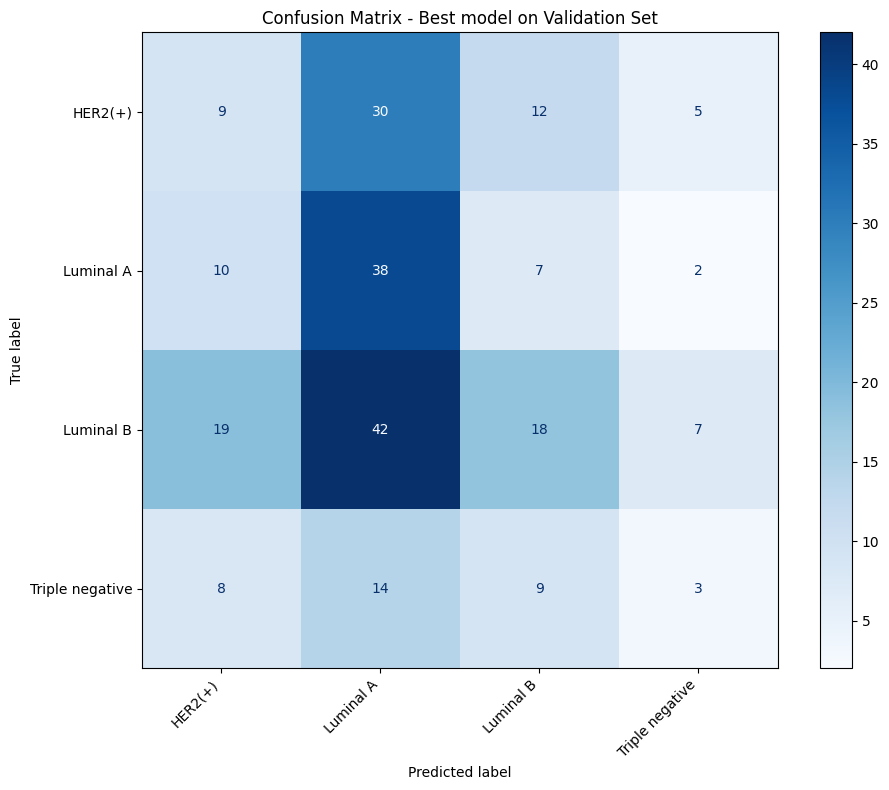

In [ ]:
# Cell 3 - Diagnostics & Confusion Matrix for best config

import pandas as pd
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Ricrea train/val split e dataloader per la best cfg
train_df, val_df, unique_labels, label_to_idx, idx_to_label = load_labels_and_split(cfg)
train_t_diag, val_t_diag = get_transforms(cfg)
train_loader_diag, val_loader_diag = create_dataloaders(
    cfg, train_df, val_df, train_t_diag, val_t_diag
)

# ---------- CLASS DISTRIBUTION ----------
print("=== CLASS DISTRIBUTION ===")
print("\nTraining set:")
print(train_df["label"].value_counts().sort_index())
print(f"Total train samples: {len(train_df)}")

print("\nValidation set:")
print(val_df["label"].value_counts().sort_index())
print(f"Total val samples: {len(val_df)}")

# ---------- TRAINING CONFIG ----------
print("\n=== TRAINING CONFIG ===")
print(f"Experiment name: {cfg.exp_name}")
print(f"Backbone     : {cfg.backbone}")
print(f"Image size   : {cfg.img_size}")
print(f"Learning rate: {cfg.lr}")
print(f"Epochs       : {cfg.epochs}")
print(f"Batch size   : {cfg.batch_size}")
print(f"Use masks    : {cfg.use_masks}")
print(f"Mask mode    : {cfg.mask_mode if cfg.use_masks else 'N/A'}")
print(f"Augmentation : {getattr(cfg, 'augmentation', 'strong')}")

# ---------- CLASS WEIGHTS ----------
class_counts = train_df["label_idx"].value_counts().sort_index().values.astype(float)
class_weights = 1.0 / class_counts
class_weights = class_weights / class_weights.sum() * len(class_counts)

print("\n=== CLASS WEIGHTS ===")
for i, (label, weight) in enumerate(zip(unique_labels, class_weights)):
    print(f"{label}: {weight:.4f} (count: {int(class_counts[i])})")

# ---------- Confusion matrix on validation set ----------
print("\n=== CONFUSION MATRIX (validation, best model) ===")

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_loader_diag:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_labels)

fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(ax=ax, cmap="Blues", values_format="d")
plt.title("Confusion Matrix - Best model on Validation Set")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# tieni idx_to_label aggiornato per l'inference
idx_to_label = idx_to_label
val_t = val_t_diag


In [ ]:
# Cell X - Sanity checks for train/val splits and masks

import os

from includes.data_utils import build_paths

print("==================================================")
print("SANITY CHECK: splits, image dirs, and masks")
print("==================================================")

# --- Paths from cfg/build_paths ---
train_img_dir, test_img_dir, mask_dir = build_paths(cfg)

print("\n[CONFIG PATHS]")
print(f"cfg.train_img_dir -> {cfg.train_img_dir}")
print(f"cfg.test_img_dir  -> {cfg.test_img_dir}")
val_img_dir_cfg = getattr(cfg, "val_img_dir", None)
print(f"cfg.val_img_dir   -> {val_img_dir_cfg}")
print(f"Resolved train_img_dir: {train_img_dir}")
print(f"Resolved test_img_dir : {test_img_dir}")
print(f"Resolved mask_dir     : {mask_dir}")

# --- Check that train_df and val_df use disjoint sample_index ---
train_names = set(train_df["sample_index"].tolist())
val_names = set(val_df["sample_index"].tolist())
overlap = train_names & val_names

print("\n[SPLIT CHECK]")
print(f"Unique train samples: {len(train_names)}")
print(f"Unique val samples  : {len(val_names)}")
print(f"Overlap (train ∩ val): {len(overlap)}")

if overlap:
    print("WARNING: these files are in BOTH train and val (showing up to 20):")
    print(sorted(list(overlap))[:20])
else:
    print("OK: train and val image sets are disjoint.")

# --- Inspect dataset dirs actually used by the loaders ---
train_ds = train_loader_diag.dataset
val_ds = val_loader_diag.dataset

print("\n[DATASET DIRS USED BY DATALOADERS]")
print(f"Train loader img_dir: {getattr(train_ds, 'img_dir', 'N/A')}")
print(f"Train loader mask_dir: {getattr(train_ds, 'mask_dir', 'N/A')}")
print(f"Val loader img_dir  : {getattr(val_ds, 'img_dir', 'N/A')}")
print(f"Val loader mask_dir : {getattr(val_ds, 'mask_dir', 'N/A')}")

# --- Check that masks exist for each split (based on sample_index -> mask_* mapping) ---
def check_masks_for_split(df, dataset, split_name: str, max_examples: int = 10):
    """Check that for each image there is a corresponding mask_* file."""
    base_mask_dir = getattr(dataset, "mask_dir", None)
    if base_mask_dir is None:
        print(f"\n[MASK CHECK - {split_name}] Dataset has no mask_dir attribute, skipping.")
        return

    missing = []
    for name in df["sample_index"]:
        # Derive mask filename from image filename
        if name.startswith("img_"):
            mask_name = "mask_" + name[4:]
        else:
            mask_name = name.replace("img", "mask")

        mask_path = os.path.join(base_mask_dir, mask_name)
        if not os.path.exists(mask_path):
            missing.append(mask_name)

    print(f"\n[MASK CHECK - {split_name}]")
    print(f"Total samples: {len(df)}")
    print(f"Missing masks: {len(missing)}")
    if missing:
        print("First missing mask files:", missing[:max_examples])
    else:
        print("OK: all expected mask_* files exist for this split.")

check_masks_for_split(train_df, train_ds, "train")
check_masks_for_split(val_df, val_ds, "val")

print("\n[SUMMARY]")
print("If:")
print(" - train/val overlap is 0,")
print(" - train loader img_dir == pp_train_data (se stai usando il pp),")
print(" - val loader img_dir   == train_data (se hai impostato val_img_dir),")
print(" - e nessuna mask risulta missing,")
print("allora split e mask sono coerenti ✅")


SANITY CHECK: splits, image dirs, and masks

[CONFIG PATHS]
cfg.train_img_dir -> pp_train_data
cfg.test_img_dir  -> pp_test_data
cfg.val_img_dir   -> None
Resolved train_img_dir: c:\Users\danie\ANN\data\pp_train_data
Resolved test_img_dir : c:\Users\danie\ANN\data\pp_test_data
Resolved mask_dir     : c:\Users\danie\ANN\data\pp_train_labels.csv

[SPLIT CHECK]
Unique train samples: 950
Unique val samples  : 233
Overlap (train ∩ val): 0
OK: train and val image sets are disjoint.

[DATASET DIRS USED BY DATALOADERS]
Train loader img_dir: c:\Users\danie\ANN\data\pp_train_data
Train loader mask_dir: c:\Users\danie\ANN\data\pp_train_data
Val loader img_dir  : c:\Users\danie\ANN\data\pp_train_data
Val loader mask_dir : c:\Users\danie\ANN\data\pp_train_data

[MASK CHECK - train]
Total samples: 950
Missing masks: 0
OK: all expected mask_* files exist for this split.

[MASK CHECK - val]
Total samples: 233
Missing masks: 0
OK: all expected mask_* files exist for this split.

[SUMMARY]
If:
 - train/

In [ ]:
# Cell 4 - Inference and submission (best model from grid search)

test_loader, test_files = create_test_loader(cfg, val_t)

submission_name = f"submission_{cfg.exp_name}.csv"

run_inference_and_save(
    cfg,
    model,
    test_loader,
    idx_to_label,
    device,
    output_csv=submission_name,
)


Number of test images: 1015
First 5 test files: ['img_0000_k1.png', 'img_0001_k3.png', 'img_0002_k1.png', 'img_0002_k10.png', 'img_0002_k2.png']

[Tile Aggregation] Found 1015 tiles from 477 original images
[Tile Aggregation] Output contains 477 original test images
[run_inference_and_save] exp_name=resnet50_optimized_40ep | filename='submission_resnet50_optimized_40ep.csv'
Saved submission to: c:\Users\danie\ANN\out\submission_resnet50_optimized_40ep.csv


'c:\\Users\\danie\\ANN\\out\\submission_resnet50_optimized_40ep.csv'

Generating Grad-CAM visualizations for validation set...
Saved Grad-CAM visualization to: out\gradcam\gradcam_resnet50_optimized_40ep.png


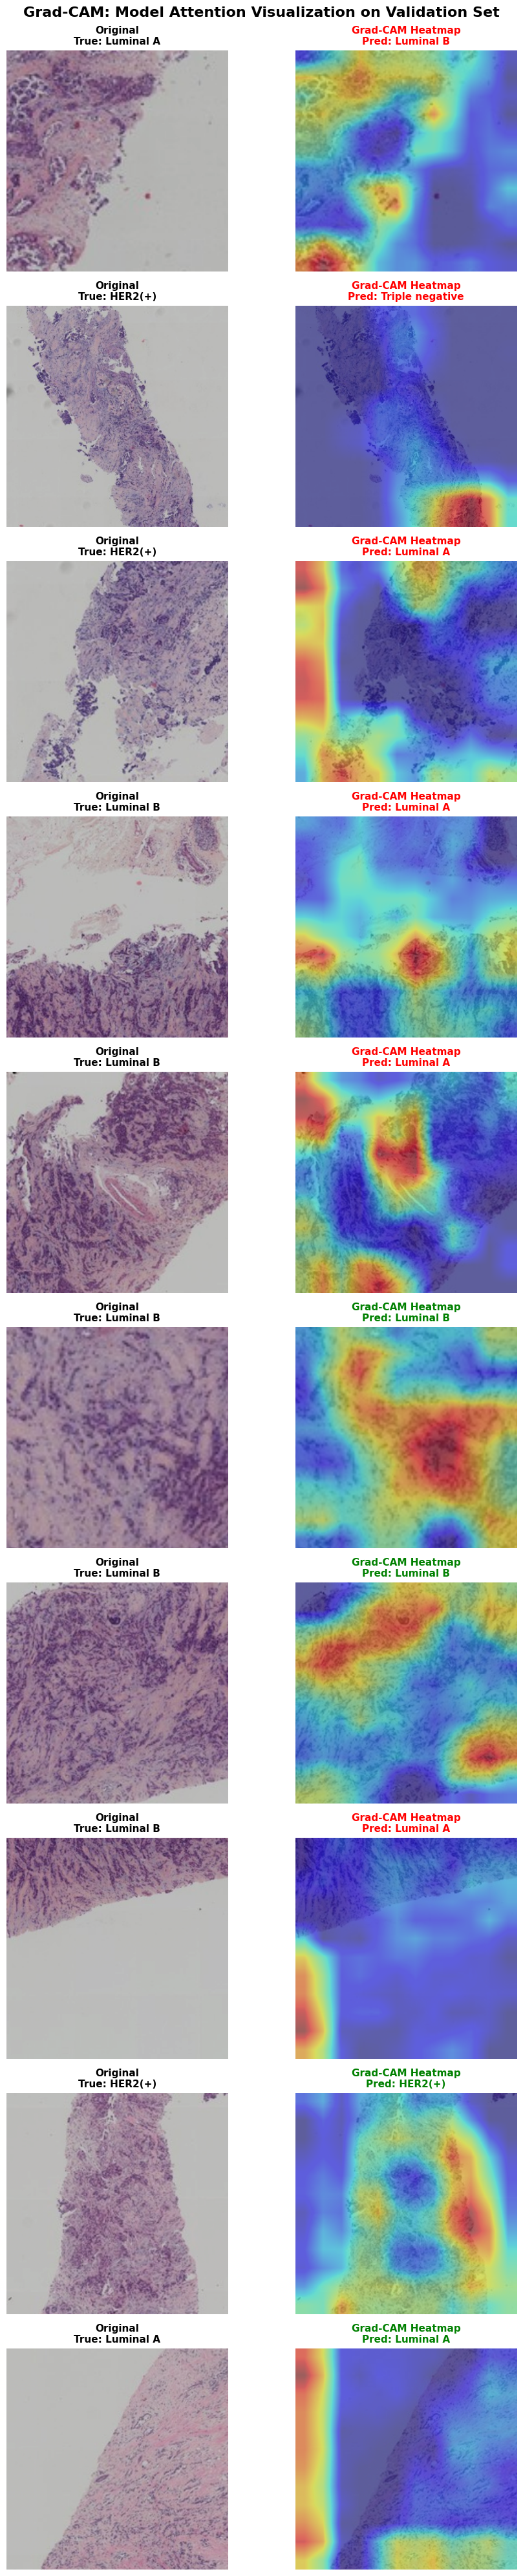

In [ ]:
# Grad-CAM Visualization

from includes.cam_utils import visualize_gradcam_for_validation

print("Generating Grad-CAM visualizations for validation set...")
visualize_gradcam_for_validation(
    model=model,
    val_loader=val_loader_diag,
    idx_to_label=idx_to_label,
    device=device,
    num_samples=10,
    save_dir=os.path.join(cfg.out_dir, "gradcam"),
    exp_name=cfg.exp_name
)


In [ ]:
if (IN_COLAB):
    full_submission_path = os.path.join(PROJECT_ROOT, cfg.out_dir, submission_name)
    print(full_submission_path)
    from google.colab import files
    files.download(full_submission_path)